---
title: "Read Mapping"
author: "Teo Sakel"
date: "10/01/2022"
execute:
  echo: false
format: 
  revealjs:
    fig-align: center
    fig-width: 6
    fig-height: 4
    fig-dpi: 300
    standalone: true
    embed-resources: true
    scrollable: true
highlight-style: pygments
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# numpy setup
from numpy.random import default_rng
rng = default_rng()

# matplotlib setup
from matplotlib.animation import FuncAnimation
from IPython import display

plt.rc('font', size=15)
plt.rc('figure', figsize=(6, 4), dpi=300)

## The Problem 

- Reads are drawn *uniformly* from the genome
- Are "slightly" corrupted by the sequencing process
- We want to find the coordinates they came from
- Ignore details like: chromosomes, reverse strands, etc

## Solutions

![](https://www.ecseq.com/support/ngs/img/ngs_read_mappers_timeline.jpeg)
> source: https://www.ecseq.com

## Aligner Space

Alingers differ along 3 main dimensions.

1. Application (DNA, mRNA, methylation)
2. How they construct their index.
3. How they perform local alignment.

![](figures/alser_fig2.webp)
> source: *Alser et al. Genome Biology (2021) 22:249. Figure 2*

## Local Alignment

- All aligners use some variation of ungapped-alignment or SW algorithm
- Optimization heuristic trade "sensitivity" for speed.

## Index Building

The 2 main technology for index construction are:


| Feature        | Hashing | BWT-FM            |
|----------------|---------|-------------------|
| Implementation | Easy    | Hard              |
| Key matching   | Exact   | Exact and Inexact |
| Index Size     | Large   | Compressed        |
| Index time     | Fast    | Slow              |
| Query Time     | Fast    | Slow              |
| Seed Length    | Fixed   | Variable          |

> source: *Alser et al. Genome Biology (2021) 22:249. Table 2*

## Hash Tables

![](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7d/Hash_table_3_1_1_0_1_0_0_SP.svg/640px-Hash_table_3_1_1_0_1_0_0_SP.svg.png)

> source: Wikipedia [Hash Table](https://en.wikipedia.org/wiki/Hash_table)

## Custom Hash Table for k-mers

- Map symbols to numerals: $A \to 0, C \to 1, G \to 2, T \to 3$
- Map positions to power of 4: $4^{k-1}, \dots, 4^2, 4^1, 4^0$
- Example: $\text{CAT} = 1 \cdot 4^2 + 0 \cdot 4^1 + 3 \cdot 4^0 = 19$

In [2]:
#| echo: true

def kmer2int(kmer, numerals={'A': 0, 'C': 1, 'G': 2, 'T': 3}):
    # reverse numerals so that 1st correspond to the 0th power etc
    return sum(numerals[c] * 4**k for k, c in enumerate(reversed(kmer)))

kmer2int("CAT")

19

## `SimpleKmerHash`

In [3]:
#| echo: true

class SimpleKmerHash: 
    def __init__(self, k):
        self.k = k
        self._alphabet = {'A': 0, 'C': 1, 'G': 2, 'T': 3} 
        self._array = [None] * 4**k  # hold space
    
    def kmer2int(self, kmer):
        assert len(kmer) == self.k
        numerals = [self._alphabet[c] for c in reversed(kmer)]
        return sum(d * 4**i for i, d in enumerate(numerals))
        
    def __getitem__(self, kmer):
        i = self.kmer2int(kmer)
        return self._array[i]
    
    def __setitem__(self, kmer, value):
        i = self.kmer2int(kmer)
        self._array[i] = value
    
    def __contains__(self, kmer):
        i = self.kmer2int(kmer)
        return self._array[i] is not None

## Example of Hash Search

In [4]:
def iter_words(text, k):
    L = len(text) - k + 1
    for i in range(L):
        yield text[i:i+k]

In [5]:
#| echo: true

p, t = "CAT", "TTGTGTGCATGTTGTTTCATCATTTAGAGATACATTGCGCTGCATCATGGTAG"
#              01234567890123456789012345678901234567890123456789012
# Occurrences:        *         *  *           *         *  *

hashTable = SimpleKmerHash(k = 3)
for i, kmer in enumerate(iter_words(t, k = 3)):
    if kmer in hashTable:
        hashTable[kmer].append(i)
    else:
        hashTable[kmer] = [i]

hashTable[p]

[7, 17, 20, 32, 42, 45]

## General Hash Search Strategy 

1. Decompose the read into a set of seeds ($k$-mers)
2. Map the seeds to the genome using a hash table
3. **Combine** the positions to find the position of the read
4. Extend the alignment to join the seeds

# Seed Design

## Spaced Seeds

![](figures/Sequence_Alignment_Example.gif)

Benefits:

1. Scan longer regions for the same $k$
2. Less redundant (less correlated with shifted version of themselves)


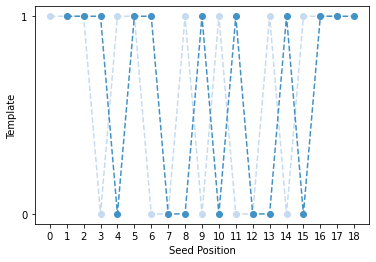

In [6]:
patternhunter = '111010010100110111'  # PatternHunter optimal seed
ss = np.array([int(i) for i in patternhunter[::-1]])  # reverse for convolution

n = 2
blues = ("#C6DBEF", "#4292C6")
for i in range(n):
    plt.plot(np.arange(len(ss)) + i, ss, 'o--', color=blues[i], label=f'shift={i}')

plt.xlabel('Seed Position')
plt.xticks(np.arange(len(ss) + n - 1))
plt.ylabel('Template')
plt.yticks([0, 1])
plt.show()

## Multiseeds

For a **single seed**, with probability of sequencing error $p_e$:

- Probability of true match: $(1-p_e)^k$
- FDR = $1/4^k$

For **multiple seeds** $|S| \gt 1$ with $k' \gt k$:

$$\text{FDR} = \frac{|S|}{4^{k'}}$$

---

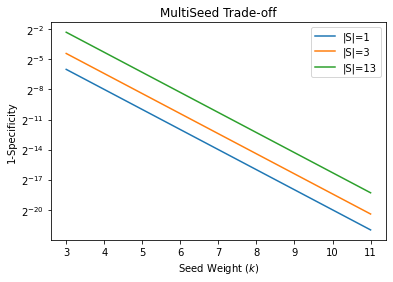

In [7]:
p = .25  # sequence similarity (0.25 = random)
k = np.arange(3, 13, 2)  # seed weight
Nseeds = [1, 3, 13]          # number of seeds


for N in Nseeds:
    FDR = N * p**k
    plt.plot(k, FDR, label=f'|S|={N}')
plt.ylabel('1-Specificity')
plt.xlabel('Seed Weight ($k$)')
plt.title('MultiSeed Trade-off')
plt.yscale('log', base=2)
plt.legend()
plt.show()

## Minimizers


*Representative* set of k-mers that can be be used to locate other $k-mer$ with which they have a significant overlap.

### $(w, k)$-minimizers

For every $w$ consecutive (shifted by 1) $k$-mers pick as the "smallest" of them according to some fixed ordering

In [8]:
def rank(x, key=None):
    # not really "rank" it does not handle draws
    rank = [0] * len(x)
    for i, o in enumerate(sorted(x, key=key)):
        rank[o] = i
    return rank

w, k = 4, 3
ref = 'GTCATGCACGTTCAC'
N = len(ref)
krank = rank(range(N-k+1), key=lambda i: ref[i:i+k])
minimizers = [i+np.argmin(krank[i:i+w]) for i in range(len(krank)-w+1)]

fig, ax = plt.subplots()

kmers = []
for i, kr in enumerate(krank):
    kmers.append(ax.plot([i, i+k-1], [kr, kr], 'k-', linewidth=2)[0])
lines = [ax.plot([], [], 'r--')[0], ax.plot([], [], 'r--')[0]]

ax.set_xticks(np.arange(N), labels=list(ref))
ax.set_xlabel('Reference')
ax.set_ylabel('Kmer Rank')
ax.set_title(f'({w}-{k})-minimizers')
ax.set_ylim(-.5, N-k+.5)

wsize = w+k-1
def animate(i):
    wkmin = kmers[minimizers[i]]
    wkmin.set_color('red')
    lines[0].set_data([i, i], [-1, N-k+1])
    lines[1].set_data([wsize + i, wsize + i], [-1, N-k+1])
    return wkmin, lines[0], lines[1]
    
anim = FuncAnimation(fig, animate, frames=len(minimizers), interval=1000, blit=True) 
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

# Seed Combination 

## Seed and Vote

[Subread](https://doi.org/10.1093/nar/gkt214) introduced *seed-and-vote*. 

![](figures/subread_seed_vote_b.png)


## Combinatoric Schemes

Some aligners aim to guarantee perfect matching under some assumptions about the distribution of errors. They make use of the pigeonhole principle or the q-gram lemma.

## Pigeonhole Principle

![](figures/pigeonhole_principle.png)


## q-gram lemma

An alignment of length $L$ with $e$ errors has at least 
$L + 1 - q(e+1)$ q-seed with no errors.

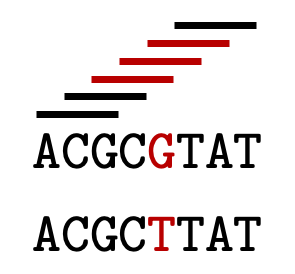


# Suffix Arrays

## Binary Search

![](https://blog.penjee.com/wp-content/uploads/2015/04/binary-and-linear-search-animations.gif)

## Binary Search

In [9]:
#| echo: true
#| code-line-numbers: "6-15"

class SmarterIndex:
    def __init__(self, array):
        # python sort tuples by 0th element
        self._array = sorted((a, i) for i, a in enumerate(array))
    
    def _bisect_left(self, x, low=0, high=None):
        if high is None:
            high = len(self._array)
        while low < high:
            mid = (low + high) // 2
            if self._array[mid][0] < x:
                low = mid + 1
            else:
                high = mid
        return low
    
    def _bisect_right(self, x, low=0, high=None):
        if high is None:
            high = len(self._array)
        while low < high:
            mid = (low + high) // 2
            if x < self._array[mid][0]:
                high = mid
            else:
                low = mid + 1
        return low
    
    def __getitem__(self, x):
        array = self._array
        i = self._bisect_left(x)
        if i >= len(array) or array[i][0] != x:
            return []
        j = self._bisect_right(x, i)
        return [a[1] for a in array[i:j]]
    
    def __contains__(self, x):
        i = self._bisect_left(x)
        return i < len(self._array) and self._array[i][0] == x
    
    @property
    def array(self):
        """Returns the original array by sorting by (the original) index"""
        yield from (a[0] for a in sorted(self._array, key=lambda a: a[1]))

## Suffix Arrays - Elements

$k$-mers are truncated suffixes we can extend them to get the full suffix

:::: {.columns}

::: {.column width="50%"}

### $k$-mers

In [10]:
text = 'abaaba'
print(text)
print('-' * len(text))
for i, kmer in enumerate(iter_words(text, k=3)):
    print(' ' * i + kmer)

abaaba
------
aba
 baa
  aab
   aba


:::

::: {.column width="50%"}

### Suffixes

In [11]:
print(text)
print('-' * len(text))
for i in range(len(text)):
    print(' ' * i + text[i:])

abaaba
------
abaaba
 baaba
  aaba
   aba
    ba
     a


:::

::::

## Suffix Arrays - Order


In [12]:
#| echo: true

def build_suffix_array(text):
    suffixes = [(text[i:], i) for i, _ in enumerate(text)]
    return [i for suffix, i in sorted(suffixes)]

text = 'abaaba'
# i  :  012345
sa = build_suffix_array(text)

In [13]:
print('sa | suffix')
print('-- | ' + len(text) * '-')
for i in sa:
    print(f'{i: >2} | {text[i:]}')

sa | suffix
-- | ------
 5 | a
 2 | aaba
 3 | aba
 0 | abaaba
 4 | ba
 1 | baaba


## `SAIndex`

Every pattern that exists in `text` will appear as the beginning of a suffix.
So we can use the suffix array as index!

In [14]:
#| echo: true
#| code-line-numbers: "4,11-13"

class SAIndex:
    def __init__(self, text):
        self.text = text
        self.sa = build_suffix_array(text)
        self.n = len(self.sa)
    
    def _bisect_left(self, p, low=0, high=None):
        if high is None:
            high = self.n
        while low < high:
            mid = (low + high) // 2
            i = self.sa[mid]
            if self.text[i:i+len(p)] < p:
                low = mid + 1
            else:
                high = mid
        return low
    
    def _bisect_right(self, p, low=0, high=None):
        if high is None:
            high = self.n-1
        while low < high:
            mid = (low + high) // 2
            i = self.sa[mid]
            if p < self.text[i:i+len(p)]:
                high = mid
            else:
                low = mid + 1
        return low
    
    def match(self, p, i):
        if i < 0 or i > len(self.text) - len(p):
            return False
        return self.text[i:i+len(p)] == p
    
    def __getitem__(self, p):
        i = self._bisect_left(p)
        if i >= self.n or not self.match(p, self.sa[i]):
            return []
        j = self._bisect_right(p, i)
        return self.sa[i:j]  # sort if you want them in order of appearance
    
    def __contains__(self, p):
        i = self._bisect_left(p)
        return self.match(p, self.sa[i])

## Suffix Array Query Example

In [15]:
#| echo: true

text = 'abaabab'
#       0123456
# ab @  *  * *

SAI = SAIndex(text)
SAI['ab']

[5, 0, 3]

# Burrows-Wheeler Transform

## Visual Representation of BWT

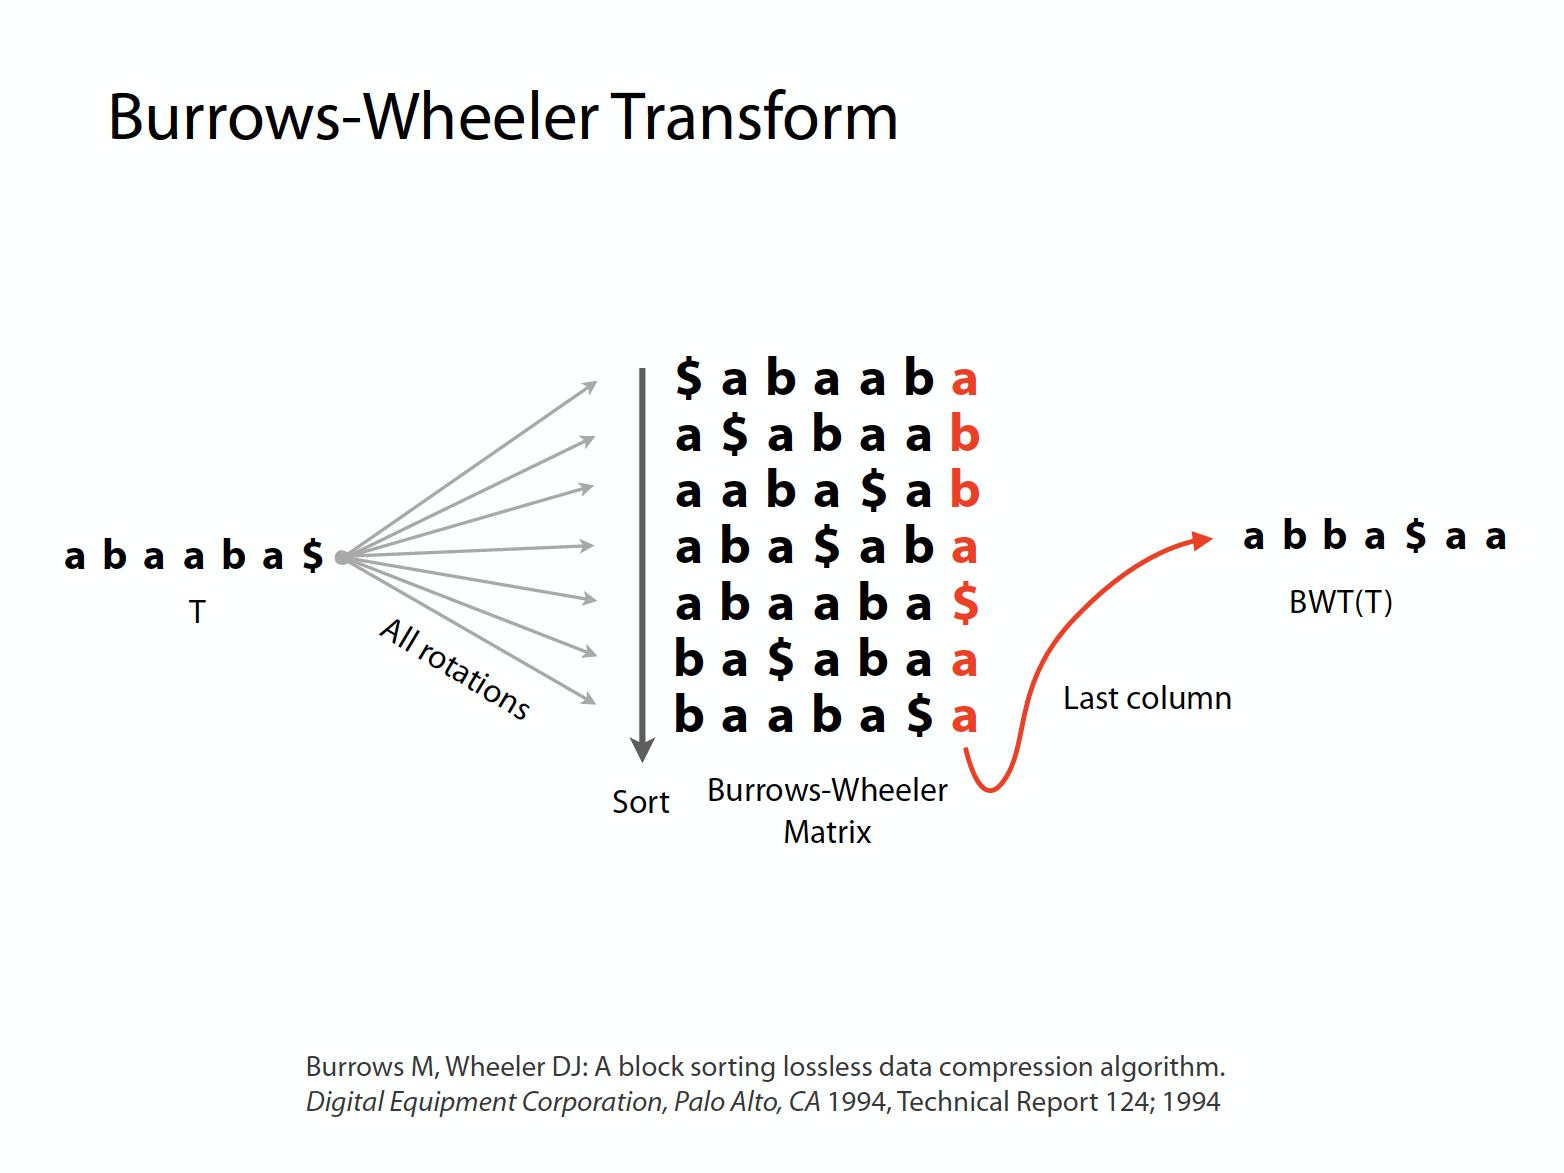


## Note on 0-based Indexing

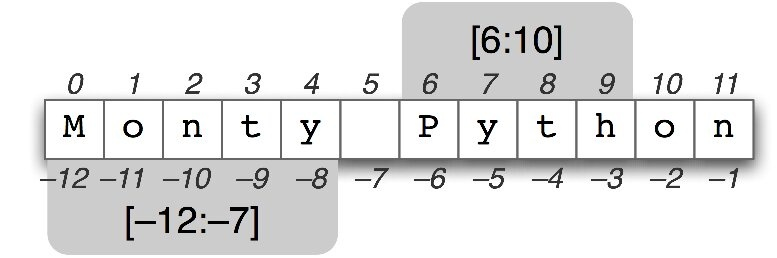

In [16]:
#| echo: true

text = 'strawberry'
# i :   0123456789
i = 5
print(text[i:], text[:i])

berry straw


## BWT in Python

In [17]:
#| echo: true

def BWT(text):
    if text[-1] != '$':
        text += '$'
    return ''.join(row[-1] for row in BWM(text))

def BWM(text):
    yield from sorted(rotations(text))

def rotations(text):
    for i, _ in enumerate(text):
        # shift "left" i positions
        yield text[i:] + text[:i]

text = 'abaaba'
BWT(text)

'abba$aa'

## Why Rotations?

- They are equivalent to suffix arrays
- Every pattern appears at the start of some rotation (`text[i:]`)

### BWT from SA

In [18]:
#| echo: true

def BWT(text, sa=None):
    if text[-1] != '$':
        text += '$'
    if sa is None:
        sa = build_suffix_array(text)
    return ''.join(text[i-1] for i in sa)

BWT('abaaba')

'abba$aa'

## The importance of `$`

It renders all the rotations unique (breaks symmetries)

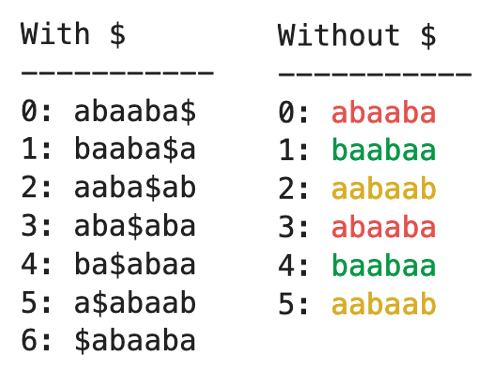

## BWT = text and index

Key BWT properties:

- It is just a permutation of the given text
- It is "sorted" by suffix 
- The characters of BWT are the ones *preceding* suffix `i` (`text[:i]`)
- **Missing ingredient**: we cannot compare a query to a suffix (`bwt[i:i+len(p)] == p`) 
  since the text is permuted

## Searching in BWT

Given a query, we work in reverse (because BWT *precedes* the suffix):

1. Find all suffixes starting with the 1st character (easy)
2. Keep all the suffixes whose next character matches in BWT (moderate)
3. Find the range of suffixes that are compatible with the query up to now (*dark-magic*)
4. Repeat for the rest until match or miss

## Searching in BWT

![](figures/FMindex.png)

## Last-First Connection

- `rotation[i] = text[i:] + text[:i]`
- `BWM[i,  0] = text[i]`
- `BWM[i, -1] = text[i-1] = BWT[i]`

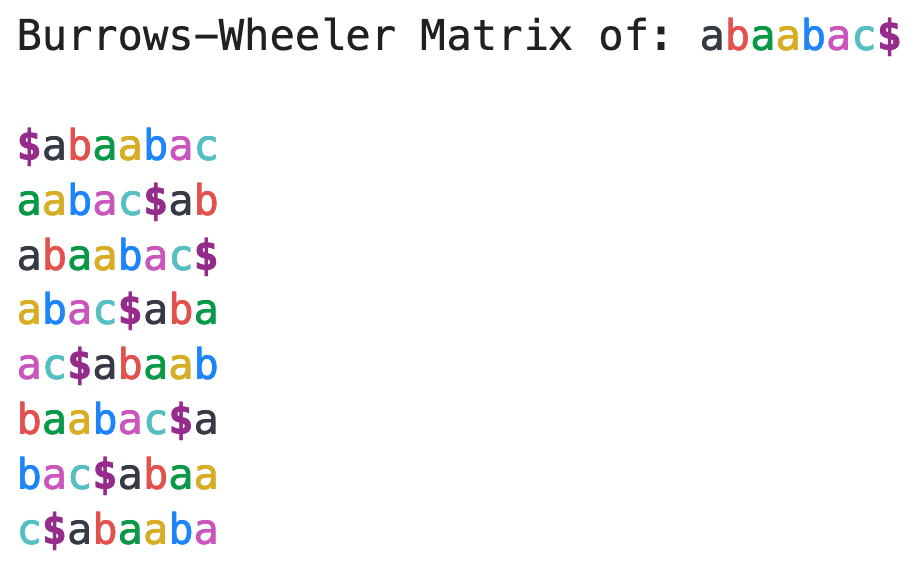

## Importance of First Column 


::: {.incremental}

- Most significant column for sorting ⇒ sorted by character
- Very compressable (4 numbers) ⇒ thus it can be stored
- Sorted based on the same context as the BWT ⇒ 
  the ranks of character are in the same order as in BWT.

:::

## Left/Right Context

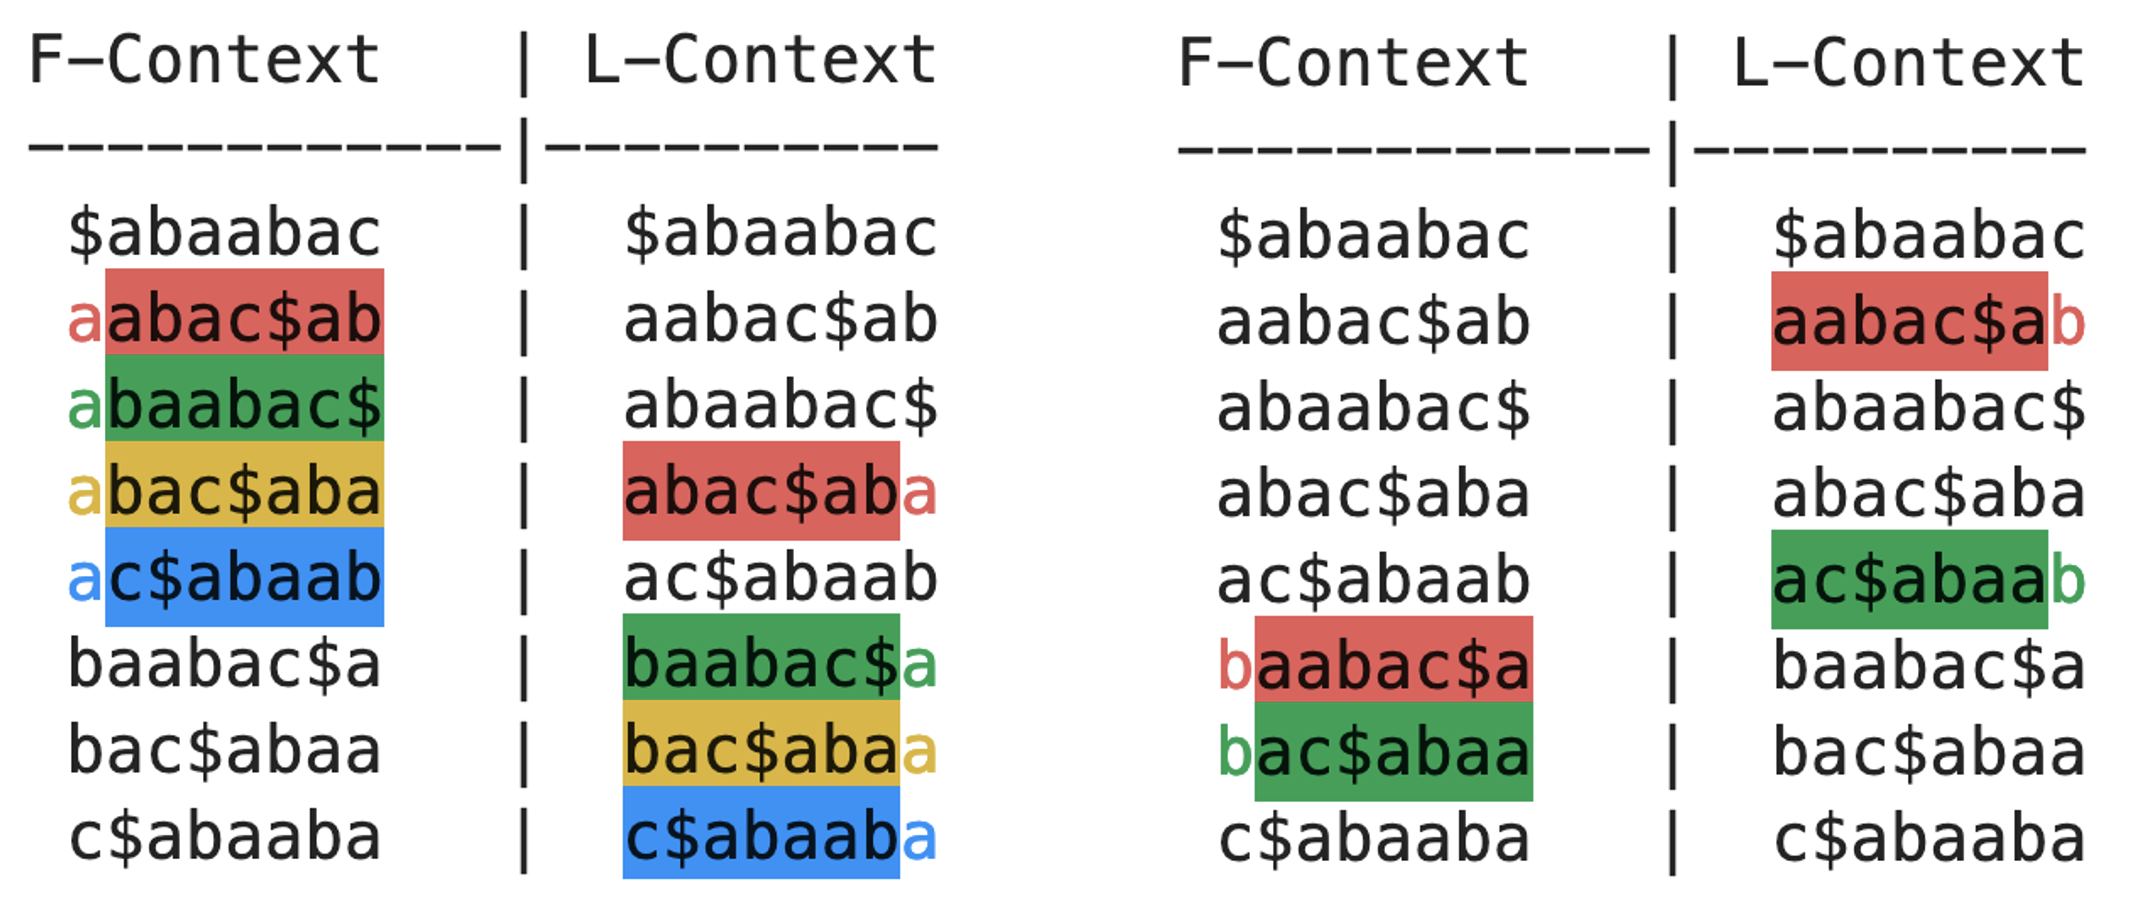

## LF Mapping


$$\text{LF}(x_i) = F(x) + i $$

where:

- $F(x)$ is the starting position of $x$ in the first column 
- $i$ is the rank (order of appearance) of $x$ in BWT.

## LF Mapping

![](figures/LF.png)

## FMIndex

![](figures/FMindex.png)

## Implementation Details {.smaller}

- The range we get is in BWT coordinates. 
  We need to keep the `sa` to map to genome
- The "vertical" search is slow. We need to keep
  track of the effective ranks
- Keep track of `sa` and effective ranks can take up a lot of space.
  We can use check-points and `LF` steps.

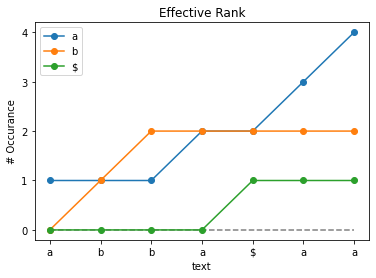

In [19]:
def rank_cdf(text):
    N = len(text)
    occ = {}
    for i, c in enumerate(text):
        if c not in occ:
            occ[c] = np.zeros(N)
        occ[c][i] = 1
    
    x = np.arange(N)
    Rm = 0
    plt.plot([0, N-1], [0, 0], '--', color = 'gray')
    for c in occ:
        y = np.cumsum(occ[c])
        plt.plot(x, y, '-o', label = c)
        if y[-1] > Rm:
            Rm = y[-1]

    plt.ylabel('# Occurance')
    plt.xlabel('text')
    plt.xticks(x, list(text))
    plt.yticks(np.arange(Rm + 1))
    plt.title('Effective Rank')
    plt.legend()
    plt.show()
    
bwt = BWT('abaaba')
rank_cdf(bwt)

## Implementation

In [1]:
#| echo: true
#| code-line-numbers: "35-39,52,53,57-59,72"

class LFCheckpoints:
    
    @staticmethod
    def effective_ranks(bwt):
        """Creates a dict of effective rank for each character in bwt character counts.
        The checkpoint are indexed by character and they have a list of counts for every checkpoint.
        The last element of the list is the total number of counts
        """
        ckps = {}
        N = len(bwt)
        for i, c in enumerate(bwt):
            if c not in ckps:
                ckps[c] = [0] * N
            ckps[c][i] = 1
        for c, occ in ckps.items():
            for i in range(1, N):
                occ[i] += occ[i-1]  # cumsum
            ckps[c] = occ
        return ckps
    
    @staticmethod
    def ranks2rle(ranks):
        """Computes a running-length encoding representation of First column"""
        first, row = {}, 0
        for c, ckp in sorted(ranks.items()):
            first[c] = row
            row += ckp[-1]  # add total tally
        return first
    
    def __init__(self, bwt):
        self.N = len(bwt)
        self.rank = self.effective_ranks(bwt)
        self.first = self.ranks2rle(self.rank)
    
    def __call__(self, c, i):
        if i < 0:
            return self.first[c]
        i = min(i, self.N - 1)
        return self.first[c] + self.rank[c][i]

class FMIndex:
    @staticmethod
    def BWT(T):
        # sa = sort i by the suffix it defines
        sa = sorted(range(len(T)), key = lambda i: T[i:])  
        bwt = ''.join(T[i - 1] for i in sa)
        return bwt, sa
    
    def __init__(self, T):
        if T[-1] != '$':
            T += '$'
        self.bwt, self.sa = self.BWT(T)
        self.LF = LFCheckpoints(self.bwt)
    
    def _match(self, p):
        low, high = 0, len(self.bwt)
        for c in reversed(p):
            low  = self.LF(c, low - 1)  # counts up to but not including low (so 1st low has index 0)
            high = self.LF(c, high) - 1 # counts up to high. -1 to turn it into index
            if low > high:
                break
        return low, high + 1  # +1 to work with slise notation
        
    def __contains__(self, p):
        low, high = self._match(p)
        return low < high
    
    def __getitem__(self, p):
        low, high = self._match(p)
        if low > high:
            return []
        return [self.sa[i] for i in range(low, high)]

## FMIndex - Example

In [2]:
#| echo: true
p, t = "CAT", "TTGTGTGCATGTTGTTTCATCATTTAGAGATACATTGCGCTGCATCATGGTAG"
#              01234567890123456789012345678901234567890123456789012
# Occurrences:        *         *  *           *         *  *
FMI = FMIndex(t)
sorted(FMI[p])

[7, 17, 20, 32, 42, 45]

## BWA Index

`BWAIndex/`:

- `genome.amb`: *ambiguous*? coordinates of non `ATCG` characters
- `genome.ann`: *annotation*? info about contigs
- **`genome.bwt`** 
- `genome.pac`: compressed version of genome (2bits/base)
- **`genome.sa`**

Also usage:

```bash
bwa aln <index> reads.fq > aln_sa.sai
bwa samse <index> aln_sa.sai reads.fq > aln-se.sam
```

## MEM seeds

> A Maximal Exact Match (MEM) is a subsequence of the read that is present in the reference genome (*exact*) and that cannot be extended further (*maximal*), either because the read ends or because the extended subsequence is not in the genome.

They are an example of variable-sized seeds and are calculated via the FM index. 

## MApping Quality (MAPQ) score

A read can be aligned to multiple positions we need to quantify our confidence in each.

$$P_M(u \mid G, r) \propto P(r|G_u^{u+l}) P(u, l)$$

Usually (but not always!) the *best* alignment is reported: $\hat{u} = \arg\max_u P_M(u \mid G, r)$

MAPQ is a quality score: $Q_M = -10 \log_{10} P(\hat{u} \neq u_{\star})$


::: {.aside}
MAPQ is not comparable across aligners
:::


## Sources of Error

1. **Contamination**: read does not come from genome
2. **Corrupted read**: base calling errors mask the true read (dropout or mis-align)
3. **Close repeats**: many regions have high score and cannot assign confidently
   

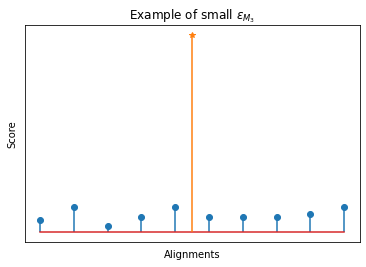

In [22]:
L = 64
x = rng.binomial(L, p=0.1, size=10)
plt.stem(np.arange(10), x)
plt.stem([4.5], L-1, linefmt='C1-', markerfmt='C1*')
plt.xticks([])
plt.xlabel('Alignments')
plt.ylabel('Score')
plt.yticks([])
plt.title('Example of small $\epsilon_{M_3}$')
plt.show()

# Appendix

## Long Read Mapping

For long (> 1kbp) reads some of these assumptions do not hold anymore like:

- **error rates**: longer reads have higher error rates ($\sim 10\%$ vs $0.1\%$)
- **error types**: longer reads are affected by indels while shorter reads mostly substitutions

These error profiles necessitate the use of a local alignment (SW) since 
we cannot bound the possible errors a-priori and perform a simple backtrack.

## Polymorphic Reference

The reference genome is just 1 individual. 
Human genome differ by 0.1% ⇒ systematic mismatches

Variance aware references:

1. Masked-genomes: with `N` at known polymorphic position.
2. [Use multiple genomes](https://doi.org/10.1101/2020.03.03.975219 ) 
   and do 2 passes over the reads
3. [Wheeler graphs](http://dx.doi.org/10.1016/j.tcs.2017.06.016) 
   which are essentially the BWT version of de-Bruijn graphs.
